# COMP5329: Assignment 1 Code

## Team member 2  Name: Dongqi Xu SID: 480529282 unikey: doxu4474

## Team member 1  Name: Yujun Liu   SID:480422097 unikey: yliu7078

# 1. Initial setup and data load

### 1.1 Import libraries

In [1]:
import h5py                     # To read the raw datasets
import numpy as np              # To do linear algebra 
import matplotlib.pyplot as pl  # To plot 
from time import time           # To calculate the timing
import seaborn as sns

D:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 2. Load and Preprocessing Data

## 2.1 Load Raw Data

In [2]:
with h5py.File('train_128.h5','r') as H:
    data = np.copy(H['data'])[0:50000]
with h5py.File('train_label.h5','r') as H:
    label = np.copy(H['label'])[0:50000]
    
with h5py.File('train_128.h5','r') as H:
    test_data = np.copy(H['data'])[50000:]
with h5py.File('train_label.h5','r') as H:
    test_label = np.copy(H['label'])[50000:]
    
    
with h5py.File("test_128.h5",'r') as H:
    pred_data = np.copy(H['data'])[:100]
    
print(data.shape)
print(label.shape)
print(test_data.shape)
print(test_label.shape)


(50000, 128)
(50000,)
(10000, 128)
(10000,)


## 2.2 See the training data label distribution

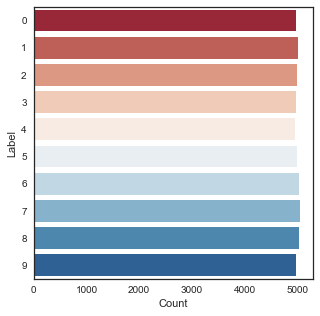

In [3]:
pl.figure(figsize=(5,5))
sns.set(style='white')
ax_label = sns.countplot(y = label, palette="RdBu")
ax_label.set(ylabel = 'Label', xlabel = 'Count')
pl.show()

## 2.3 Preprocessing data

### We transform the data to array type. Then normalize the input data by $x_i=\frac{x_i-\mu}{\delta}$. Finally transform data into one-hot label.

In [4]:
print(label[0])
print(test_label[0])
label = np.array(np.eye(10)[label.reshape(-1)], dtype=float)
test_label = np.array(np.eye(10)[test_label.reshape(-1)], dtype=float)
print(label[0])
print(test_label[0])

9
9
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [5]:
def normalize(input_data):
    
    mu = input_data.mean()
    sigma = input_data.std()
    normalized_data = (input_data - mu) / sigma
    
    return normalized_data

#print(data[0])
data = normalize(data)
test_data = normalize(test_data)
pred_data = normalize(pred_data)
#print(data[0])

In [6]:
train_data = np.array(data, dtype=float)
test_data = np.array(test_data, dtype=float)
train_label = np.array(label, dtype=float)
test_label= np.array(test_label, dtype=float)
pred_data = np.array(pred_data, dtype=float)

# 3. Main Classes

## 3.1 Activation class

In [7]:
class Activation:
    
    def __init__(self, activation='relu'):            
        if activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv

        if activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        if activation == 'leaky relu':
            self.f = self.leaky_relu
            self.f_deriv = self.leaky_relu_deriv
    
    def __tanh(self, x):
        return np.tanh(x)
    
    def leaky_relu (self,x):
        return np.maximum(x,0.1*x)  

    def leaky_relu_deriv (self,a):
        # a = np.maximum(x,0.1*x)
        a[a<0] = 0.1
        a[a>=0] = 1
        return a

    def __tanh_deriv(self, a):
        return 1.0 - a**2

    def __relu(self, x):
        x = x*(x>0)
        return x

    def __relu_deriv(self, a):
        a = 1.0*(a>0)
        return a  

## 3.2 Input and output layer classes

### Due to convinent for forward and backward propogation processing of input and output layer, we create a class for input and output layer

In [8]:
class IO_Layer:
    def __init__(self, n_in, n_out, W=None, b=None, activation='relu'):
        self.input = None
        self.activation = Activation(activation).f
        self.activation_deriv = Activation(activation).f_deriv

        # Kaiming He initialization 
        self.W = np.random.randn(n_in, n_out) * np.sqrt(2.0 / n_in) # w is to N(mean = 0, std = sqrt( 2.0 / fan_in))
        self.b = np.zeros(n_out,)
        self.n_in = n_in
        self.n_out = n_out

        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        self.velocity_W = np.zeros(self.W.shape)
        self.velocity_b = np.zeros(self.b.shape)
        
        self.sqr_grad_W = np.zeros(self.W.shape) 
        self.sqr_grad_b = np.zeros(self.b.shape)        
        
        

    # create initial parameters for each layer 
    def forward(self, input):

        lin_output = np.dot(input, self.W) + self.b
        self.output = (lin_output if self.activation is None else self.activation(lin_output))
        self.input = input
        return self.output
    
    # to predict unlabele   
    def forward_predict(self, input):
    
        lin_output = np.dot(input, self.W) + self.b
        self.output = (lin_output if self.activation is None else self.activation(lin_output))
        self.input = input
        return self.output

    def backward(self, delta):
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = np.sum(delta)
        delta_ = delta.dot(self.W.T) * self.activation_deriv(self.input)
        # return delta_ for next layer
        return delta_
    
    

## 3.3 Hidden Layer Class

In [9]:
class HiddenLayer:
    def __init__(self, n_in, n_out, W=None, b=None, activation='relu', 
                 dropout=False, weight_decay=False):
        
        self.input = None
        self.activation = Activation(activation).f
        self.activation_deriv = Activation(activation).f_deriv
        
        self.W = np.random.randn(n_in, n_out) * np.sqrt(1.0 / n_in)
        self.b = np.zeros(n_out,)
        self.n_in = n_in
        self.n_out = n_out
        
        #to set dropout P
        self.dropout = 1-dropout
        #whether do weight_decay
        self.weight_decay = weight_decay
        
        #parameters for GD
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        #parameters for momentum and adam
        self.velocity_W = np.zeros(self.W.shape)
        self.velocity_b = np.zeros(self.b.shape)
        
        self.sqr_grad_W = np.zeros(self.W.shape) 
        self.sqr_grad_b = np.zeros(self.b.shape)        

        # parameters for BN
        self.gamma_BN = np.ones((1, n_in))
        self.beta_BN = 0 
        self.grad_gamma_BN = np.ones(self.gamma_BN.shape)
        self.grad_beta_BN = 0 
        self.BN_mean_total = []
        self.BN_var_total = []
    

    def forward(self, input,BN=False):
        
        # pass output to next layer
        lin_output = np.dot(input, self.W) + self.b
        self.output = (lin_output if self.activation is None else self.activation(lin_output))
        self.input = input
        if self.dropout is True:
            
            prob = np.random.binomial(1,self.dropout,size=self.W)
            self.output *= prob
        
        
        if BN is True:
            input_mean = input.mean(axis=0, keepdims=True)
            input_var = input.var(axis=0, keepdims=True)
            input = (input - input_mean) / np.sqrt(input_var + 1e-5)
            input = input * self.gamma_BN + self.beta_BN
            self.BN_mean_total.append(input_mean)
            self.BN_var_total.append(input_var)            
               
        return self.output

    def forward_predict(self, input,BN=False):
        if BN is True:
            input_mean = np.mean(self.BN_mean_total)
            input_var = np.mean(self.BN_var_total)
            input = (input - input_mean) / np.sqrt(input_var + 1e-5)
            input = input * self.gamma_BN + self.beta_BN
                    
        lin_output = np.dot(input, self.W) + self.b
        self.output = (lin_output if self.activation is None else self.activation(lin_output))
        self.input = input
        return self.output

    def backward(self, delta,BN=False):

        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = np.sum(delta)
 
        delta_ = delta.dot(self.W.T) * self.activation_deriv(self.input)
    
        if BN is True:
            self.grad_gamma_BN = np.mean(delta_, axis=0, keepdims=True) * self.gamma_BN
            self.grad_beta_BN = np.mean(delta_)
        
            delta_ = delta_ * self.gamma_BN    
        return delta_


## 3.4 Main Class

In [10]:
class MLP:
    def __init__(self, input_layers, hidden_layers, output_layers, activation='leaky relu',softmax=False,
                 dropout=False, weight_decay=False):
        
        # create list to store all parameters
        self.layers = []
        self.params = []

        self.activation = activation
        self.softmax = softmax
        
        # set whether implement weight decay and init
        self.weight_decay = weight_decay
        if weight_decay is True:
            print("Using weight_decay")



        # create input layer
        self.layers.append(IO_Layer(input_layers, hidden_layers[0], activation=activation))
        # add hidden layers
        for i in range(len(hidden_layers) - 1):
            self.layers.append(HiddenLayer(hidden_layers[i], hidden_layers[i + 1], activation=activation, dropout=dropout,
                                          weight_decay=self.weight_decay))
        # add output layer
        self.layers.append(IO_Layer(hidden_layers[-1], output_layers, activation=activation))
        print("===============================================")
        print("Defaultly calculte cross-entropy-loss of output")
        print("===============================================")
    def forward(self, input):
        for layer in self.layers:
            output = layer.forward(input)
            input = output
        return output

    def forward_predict(self, input):
        # only use it in predict
        for layer in self.layers:
            output = layer.forward_predict(input)
            input = output
        return output

    def criterion(self, y, y_hat):
        if not self.softmax:
            activation_deriv = Activation(self.activation).f_deriv
            error = y - y_hat
            loss = error**2 
            delta = -error * activation_deriv(y_hat) / 512
            
            loss = np.sum(loss)
            
        if self.softmax:
            y_ = np.exp(y_hat-np.max(y_hat,axis=1,keepdims=True))
            y_hat = y_ / (np.sum(y_, axis=1, keepdims=True))
             
            loss = -np.sum(y*(np.log(y_hat)))
            delta =  -(y-y_hat)/512           
            #print(loss,delta)
        return loss, delta

    def backward(self, delta):
        for layer in reversed(self.layers):
            delta = layer.backward(delta)

    def update(self,learning_rate=0.001,it=0,BN=False):
        if BN is True:
            layer.gamma_BN -= lr * layer.grad_gamma_BN
            layer.beta_BN -= lr * layer.grad_beta_BN            
            layer.velocity_W = gamma_MT * layer.velocity_W + lr * layer.grad_W
            layer.W -= layer.velocity_W
            layer.velocity_b = gamma_MT * layer.velocity_b + lr * layer.grad_b
            layer.b -= layer.velocity_b      

        for layer in self.layers:
            if self.weight_decay:
            #L_new_W=L_old_W+0.5*lambda||W||**2  -> W-grad_W = W - learning_rate*(delta+lambda*W) -> (1-laerning_rate*lambda)*W-delta
            #W = W*(1-laerning_rate*lambda)  
                layer.W *= (1-learning_rate*self.weight_decay) 
            # Momentum
            if self.optimizer == 'momentum':
                
                beta=0.9
                layer.velocity_W = beta*layer.velocity_W + (learning_rate)*layer.grad_W
                layer.velocity_b = beta*layer.velocity_b + (learning_rate)*layer.grad_b
                # Update 
                layer.W -= layer.velocity_W
                layer.b -= layer.velocity_b 
            # Adam
            elif self.optimizer == 'adam':
                #layer.adam_update(learning_rate,it)
                t = it
                beta1=0.9
                beta2=0.999
                epsilon=1e-3
                # Update m
                layer.velocity_W = beta1*layer.velocity_W + (1-beta1)*layer.grad_W
                layer.velocity_b = beta1*layer.velocity_b + (1-beta1)*layer.grad_b

                # Calculate  v
                layer.sqr_grad_W = beta2 * layer.sqr_grad_W + (1-beta2) * np.power(layer.grad_W,2)
                layer.sqr_grad_b = beta2 * layer.sqr_grad_b + (1-beta2) * np.power(layer.grad_b,2)
        
                # Correct m_hat
                velocity_corrected_W = layer.velocity_W / (1-beta1**(t+1)) 
                velocity_corrected_b = layer.velocity_b / (1-beta1**(t+1))  

                # Correct v_hat
                sqr_grad_corrected_W = layer.sqr_grad_W / (1-beta2**(t+1)) 
                sqr_grad_corrected_b = layer.sqr_grad_b / (1-beta2**(t+1))          
        
                # Update
                layer.W -= learning_rate * (velocity_corrected_W/(np.sqrt(sqr_grad_corrected_W+epsilon)))# added epsilon 
                layer.b -= learning_rate * (velocity_corrected_b/(np.sqrt(sqr_grad_corrected_b+epsilon))) # added epsilon  
            
            else:
                layer.W -= learning_rate * layer.grad_W
                layer.b -= learning_rate * layer.grad_b
            

    # mini batch training
    def mini_batches_random(self, X, y, mini_batch_size):
        # create mini-batches for each epoch, randomly choose elements for batches
        num_samples = X.shape[0]
        mini_batches = []

        permutation = list(np.random.permutation(num_samples))
        rand_X = X[permutation, :]
        rand_y = y[permutation, :]

        num_complete = num_samples // mini_batch_size

        for i in range(num_complete):
            mini_batch_X = rand_X[i * mini_batch_size: (i + 1) * mini_batch_size, :]
            mini_batch_y = rand_y[i * mini_batch_size: (i + 1) * mini_batch_size, :]

            mini_batch = (mini_batch_X, mini_batch_y)
            mini_batches.append(mini_batch)

        if num_samples % mini_batch_size != 0:
            mini_batch_X = rand_X[num_complete * mini_batch_size:, :]
            mini_batch_y = rand_y[num_complete * mini_batch_size:, :]

            mini_batch = (mini_batch_X, mini_batch_y)
            mini_batches.append(mini_batch)
        return mini_batches
    
    def fit(self, X, y, learning_rate=0.1, epochs=100, gd='mini_batch', mini_batch_size=64, optimizer=None,BN=False):
        X = np.array(X)
        y = np.array(y)
        
        self.optimizer = optimizer
        self.BN=BN
        epochs += 1 # to revise the range of epochs, plus 1 for modification
        to_return = np.zeros(epochs)
        
        if gd == 'SGD':
            for k in range(epochs):
                loss = 0
                i = np.random.randint(X.shape[0])
                # forward pass
                y_hat = self.forward(X[i])
                # backward pass
                loss, delta = self.criterion(y[i], y_hat)
                self.backward(delta)
                # update
                self.update(learning_rate, momentum, gamma_MT)
                to_return[k] = np.mean(loss)
                if k%500 == 0 and k!=0:
                    print("the epoch {} loss: {}".format(str(k), to_return[k]))

        # Implement Mini Batch
        if gd == 'mini_batch':
            for k in range(epochs):
                loss = np.zeros(X.shape[0])
                mini_batches = self.mini_batches_random(X, y, mini_batch_size)

                for it, mini_batch in enumerate(mini_batches):
                    loss_it = 0
                    (mini_batch_X, mini_batch_y) = mini_batch
                    
                    y_hat = self.forward(mini_batch_X)
                    
                    loss_it, delta = self.criterion(mini_batch_y, y_hat)
                    loss[it] = np.mean(loss_it)
                    
                    self.backward(delta)
                    self.update(learning_rate,it)

                    to_return[k] = np.mean(loss)
                # print loss of epochs
                if k%2 == 0 and k!=0:
                    print("the epoch {} loss: {}".format(str(k), to_return[k]))
                    
        return to_return

    def predict(self, x, model):
        x = np.array(x)
        output = model.forward_predict(x)
        if self.softmax is True:
            x = np.array(x)
            output = model.forward_predict(x)
            exps_out = np.exp(output-np.max(x,axis=1,keepdims=True))
            output = exps_out / (np.sum(exps_out, axis=1, keepdims=True))

        return output

## 4.Classifier Development, Training and Analysis

Defaultly calculte cross-entropy-loss of output
the epoch 2 loss: 0.6374233309804971
the epoch 4 loss: 0.5505936166952546
the epoch 6 loss: 0.5038026519347868
the epoch 8 loss: 0.47233821518874547
the epoch 10 loss: 0.45064557097634655
the epoch 12 loss: 0.43392706213689897
the epoch 14 loss: 0.4202742864411453
the epoch 16 loss: 0.4090172792156234
the epoch 18 loss: 0.4003388217637358
the epoch 20 loss: 0.3915179671515108
the epoch 22 loss: 0.38422388358649684
the epoch 24 loss: 0.3790088455463915
the epoch 26 loss: 0.37333461093400155
the epoch 28 loss: 0.3664700480770211
the epoch 30 loss: 0.36120395314799186
the epoch 32 loss: 0.35683175141674484
the epoch 34 loss: 0.35246010011700024
the epoch 36 loss: 0.3489648770959026
the epoch 38 loss: 0.34450362113575334
the epoch 40 loss: 0.3404852577513173
the epoch 42 loss: 0.33801773263714147
the epoch 44 loss: 0.3344143228133715
the epoch 46 loss: 0.33084854931742047
the epoch 48 loss: 0.32766776881879317
the epoch 50 loss: 0.32519896348

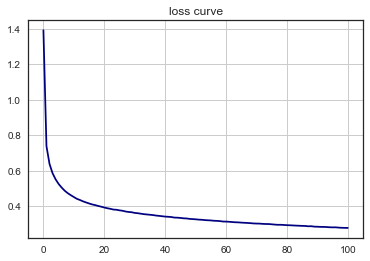

In [11]:
start_time = time()

nn = MLP(128, [100, 64, 32], 10, 'relu', dropout=False,softmax=True,weight_decay=0) 

CROSS_E = nn.fit(data,label, learning_rate=0.02, epochs=100, gd='mini_batch', mini_batch_size=512,optimizer= None ,BN= False)

print("---------------------------------\n")
print('last loss:%f' % CROSS_E[-1])

end_time = time()
print("===============================================")
print("Fit time: %2f seconds" % (end_time - start_time))
print("===============================================")
pl.figure()
pl.title('loss curve') 
pl.plot(CROSS_E, color="navy")
pl.grid()
pl.show()

## 4.1. Calculate testing accuracy function

In [12]:
def calculateAcc(pred_label, real_label):
    acc_num = 0
    for i in range(len(pred_label)):
        if pred_label[i].tolist() == real_label[i].tolist():
            acc_num += 1
            #print(pred_label[i],real_label[i])
        #if pred_label[i].tolist() != real_label[i].tolist():
            #print(pred_label[i],real_label[i])
    print("number of correct prediction : ",acc_num)
    acc = acc_num / len(real_label)
    print("the accuracy is: {:.4%}".format(float(acc)))
    return acc

In [13]:
def predict_data(test_data, model):
    predictLabel = model.predict(test_data, model)
    predict_array = np.array(predictLabel)
    #print(predict_array)
    predictLabel = (predict_array == predict_array.max(axis=1, keepdims=1)).astype(float)

    return predictLabel

In [14]:
pred_label_test = predict_data(test_data, nn)
acc = calculateAcc(pred_label_test, test_label)
# show the accuracy rate of sorting test data 
#pred_label

number of correct prediction :  8775
the accuracy is: 87.7500%


## 4.2. Build confusion matrix functions

In [15]:
test_pred_list = []
for one_hot_label in pred_label_test.tolist():
    #print(one_hot_label)
    test_label1 = one_hot_label.index(max(one_hot_label))
    test_pred_list.append(test_label1)
print(len(test_pred_list))

10000


In [16]:
with h5py.File('train_label.h5','r') as H:
    test_label_raw = np.copy(H['label'])[50000:]

print(test_label_raw[:10])
print(test_pred_list[:10])

[9 2 1 0 2 7 9 3 1 1]
[9, 2, 1, 0, 2, 7, 9, 3, 1, 1]


In [17]:
def build_confusion_matrix(testLabel, realLabel):
    from sklearn.metrics import confusion_matrix
    #only import that labrary for drawing confusion matrix
    CM = confusion_matrix(testLabel, realLabel, labels=np.array(range(10)))
    fig, ax = pl.subplots(figsize=(10,8))
    fig.suptitle("Confusion Matrix", fontsize=20)
    heatmap = ax.pcolor(CM, cmap=pl.cm.Blues)

    ax.set_xticks(np.arange(CM.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(CM.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    fig.colorbar(heatmap)
    ax.set_xticklabels(np.array(range(10)), minor=False)
    ax.set_yticklabels(np.array(range(10)), minor=False)
    pl.show()

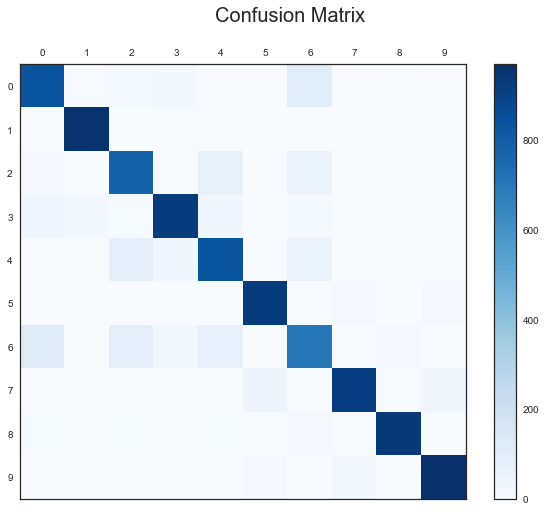

In [18]:
 build_confusion_matrix(test_pred_list,test_label_raw)

## 5. Prediction

In [19]:
pred_label = predict_data(pred_data, nn)
#print(pred_label)
final_pred_list = []
for one_hot_label in pred_label.tolist():
    #print(one_hot_label)
    true_label = one_hot_label.index(max(one_hot_label))
    final_pred_list.append(true_label)
    
f = h5py.File('predicted_labels.h5','w')   
f['data'] = pred_data 
f['labels'] = final_pred_list          
f.close() 

print(final_pred_list)

[9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 2, 8, 0, 2, 5, 7, 5, 1, 2, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 0, 1, 6, 7, 6, 7, 2, 1, 2, 6, 4, 2, 5, 8, 2, 2, 8, 6, 8, 0, 7, 7, 8, 5, 1, 1, 3, 4, 7, 8, 7, 0, 2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2, 0, 6, 5, 3, 6, 7, 1, 8, 0, 1, 2, 2]


In [20]:
print(len(final_pred_list))

100
